# Assignment 2 - Lunar Lander

### Task 1

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
from PIL import Image
import PIL
from numpy import newaxis

from imblearn.over_sampling import SMOTE
from random import randint

## Data

* Dataset is formed from the given images in the folder 'LunarLanderFramesPart1'
* We have used GreyScale images.
* We have resized images to size (84,84)
* we have extracted target labels from the given filename and set this in the data.
* We have used sequential images to randomly choose a common input for a set of images.
* We have removed data imbalancing by using over_sampling using SMOTE

In [17]:
# dataset name
dataset_name = 'LunarLanderFramesPart1'

# assuming data is contained in a train and a validation set
train_data_dir = dataset_name

# Set up some parmaeters for data loading
sample_rate = 0.1

# Threshold for choosing the number of sequential images having same target label.
threshold = 10

# desired dimensions of our images.
img_width, img_height = 84, 84

# different backends (e.g. tensorflow and theano) use different orderings for image data - fix this!
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)

Load image data.

In [18]:
image_class_folder = train_data_dir + "/"
    
# generate filenames from the data folder and do sampling
image_filenames = [i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset

# Sort image filenames before usage to get the sequential images
image_filenames.sort()

# Number of files in the folder
num_of_files = len(image_filenames)

# List to store the selected images from the folder
images_seq = []
i=0

# Loop to select one file from a sequence of files with same action
while i < num_of_files:
    count = 0
    image_file = image_filenames[i]
    
    # Fetch the target variable from the filename
    action = (image_file.split('_')[3]).split('.')[0]
    temp_seq = []
    continuous = True
    
    # Get the sequential images
    while continuous and i < num_of_files - 1:
        i += 1
        if not (action == image_filenames[i][len(image_file) - 6] and count < threshold):
            continuous = False
            break
        temp_seq.append(image_filenames[i])
        count += 1
    
    size = len(temp_seq)
    val = 0
    
    # Choose representative image among set of sequential images
    if len(temp_seq) == 0:
        images_seq.append(image_filenames[i-1])
    elif len(temp_seq) > 0:
        val = randint(0, size-1)
        images_seq.append(temp_seq[val])
    i += 1
     
print(len(images_seq))

17187


In [19]:
# Randomly sample the input images
images_seq = random.sample(image_filenames, int(len(images_seq)*sample_rate))

In [20]:
# Number of image files
seq_len = len(images_seq)

# Number of target labels
num_classes = 4

# Initialise arrays for data storage
X_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.str)

X_data_part = np.ndarray((seq_len, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

# # Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, img in enumerate(images_seq):

    try:
        # Low the images and resize them
        image = cv2.imread(image_class_folder + img, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        
        # Converting 2D image to 3D image
        image = image[:,:,newaxis]
        
        # If channel order of network does not match open cv format swap it
        if K.image_data_format() == 'channels_first':
            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
        
        # Add image data to data array and normalise
        X_data_part[i] = image
        X_data_part[i] = X_data_part[i]/255
        
        label = (img.split('_')[3]).split('.')[0]
        
        # Add label to label array
        y_data = np.append(y_data, label)
        
        if i%100 == 0: print('Processed {} of {}'.format(i, seq_len))
    except Exception as e:
        print(str(e))
        
# Append the part to the overall data array
X_data = np.append(X_data, X_data_part, axis=0)
    
print("Data shape: {}".format(X_data.shape))
print("Target Label shape: {}".format(y_data.shape))

Processed 0 of 1718
Processed 100 of 1718
Processed 200 of 1718
Processed 300 of 1718
Processed 400 of 1718
Processed 500 of 1718
Processed 600 of 1718
Processed 700 of 1718
Processed 800 of 1718
Processed 900 of 1718
Processed 1000 of 1718
Processed 1100 of 1718
Processed 1200 of 1718
Processed 1300 of 1718
Processed 1400 of 1718
Processed 1500 of 1718
Processed 1600 of 1718
Processed 1700 of 1718
Data shape: (1718, 84, 84, 3)
Target Label shape: (1718,)


### Handling Data imbalancing

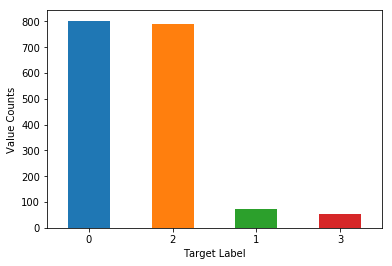

In [21]:
# Showing the plot before balancing the data

pd.Series(y_data).value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('Target Label')
plt.ylabel('Value Counts')
plt.show()

In [22]:
# Extracting values to give 2D input for balancing the data
# i - Index of the data
# y_data - Target data labels

samp_x = []
for i, val in enumerate(X_data):
    samp_x.append((i,int(y_data[i])))

samp_y = []
for i in range(len(y_data)):
    samp_y.append(int(y_data[i]))

smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_sample(samp_x, samp_y)

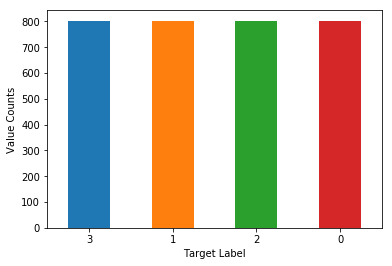

In [23]:
# Target data labels after handling data imbalancing

pd.Series(y_sm).value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('Target Label')
plt.ylabel('Value Counts')
plt.show()

## Preparing data after handling data imbalancing

In [31]:
X_n = []
y_n = []
for i, val in enumerate(X_sm):
    temp = val[0]
    X_n.append(X_data[temp])
    y_n.append(y_data[temp])

X_data = np.asarray(X_n)
y_data = np.asarray(y_n)

Split data into training and test partitions

In [45]:
# Perfrom split to train, validation, test
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.20, train_size = 0.8)

Reshape output data for use with a neural network.

In [50]:
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

y_train_plus_valid_num = y_train_encoder.fit_transform(y_train_plus_valid)
y_train_plus_valid_wide = keras.utils.to_categorical(y_train_plus_valid_num, num_classes)

y_valid_num = y_train_encoder.fit_transform(y_valid)
y_valid_wide = keras.utils.to_categorical(y_valid_num, num_classes)

Record the number to label mapping 

In [34]:
classes_num_label = dict()

for idx, lbl in enumerate(y_train_encoder.classes_):
    classes_num_label[idx] = lbl

Print a few randomly sampled example images.

C:\Users\Salman\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


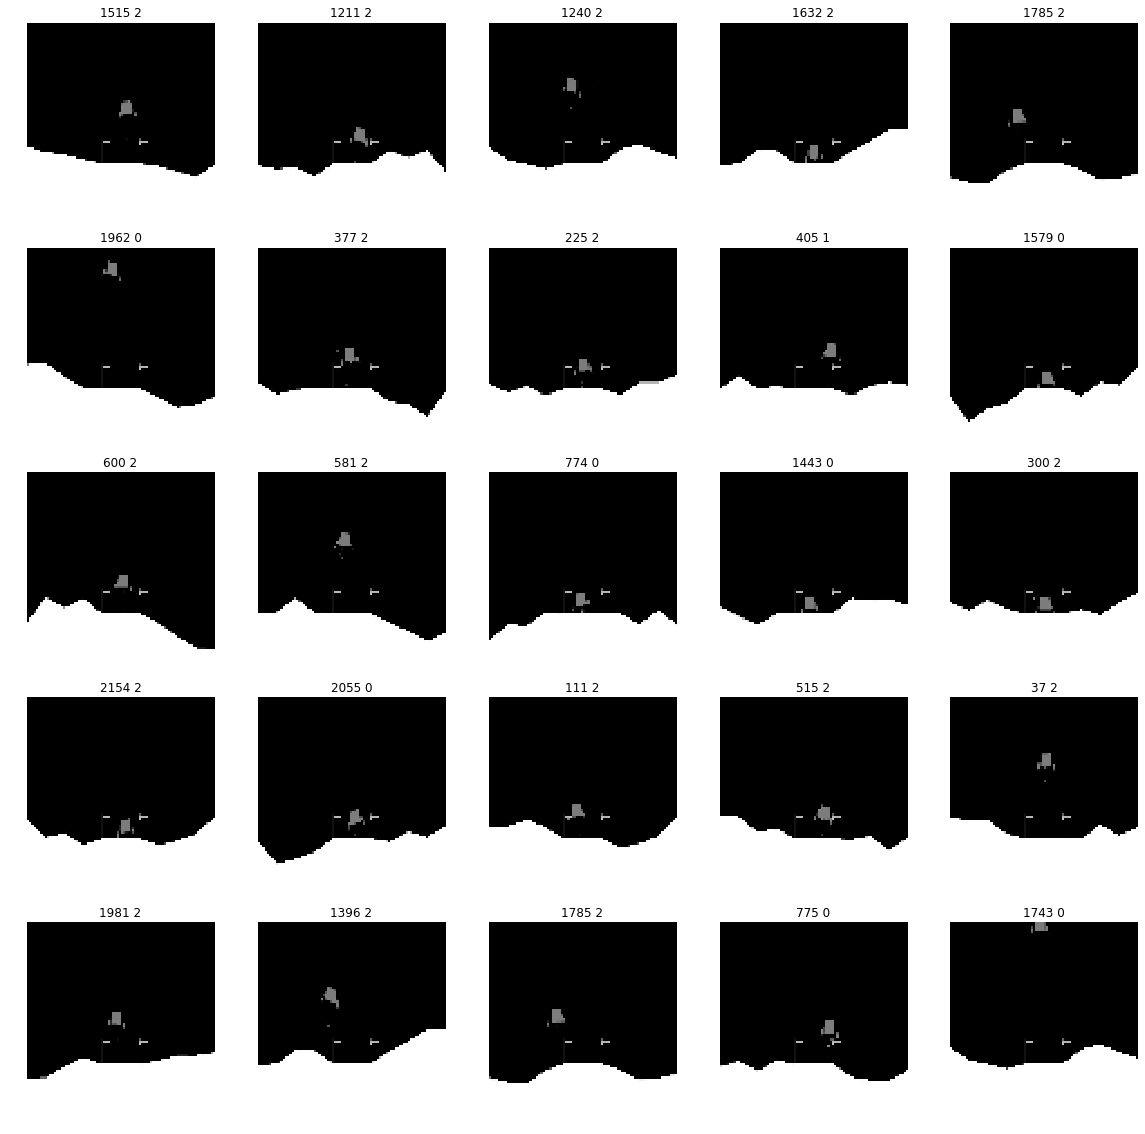

In [35]:
pltsize=4
row_images = 5
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(sp.misc.toimage(X_train[i_rand]))
    plt.title((str(i_rand) + " " + y_train[i_rand]))
    # print('Training sample',i_rand,': class:',y_train[i_rand])

## Modelling

Create model architecture

In [36]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 82, 82, 32)        896       
_________________________________________________________________
activation_11 (Activation)   (None, 82, 82, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 39, 39, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 17, 17, 64)        18496     
__________

Train the model. We allow the model to overfit but save the best set of weights based on validation loss as we go. Then at the end of training (assuming the model has overfit) we revert back to the saved model.

In [41]:
batch_size = 128
epochs = 20

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_LunarLander.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)

history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

# Saving the model on use on lunar_lander_ml_player
model.save('./model_sec.h5')

#reload best weights
model.load_weights(best_weights_filepath)

Train on 1798 samples, validate on 450 samples
Epoch 1/20
1798/1798 [==============================] - 36s 20ms/step - loss: 0.2127 - acc: 0.9096 - val_loss: 0.2713 - val_acc: 0.8883
Epoch 2/20
1798/1798 [==============================] - 41s 23ms/step - loss: 0.1970 - acc: 0.9191 - val_loss: 0.2633 - val_acc: 0.8950
Epoch 3/20
1798/1798 [==============================] - 41s 23ms/step - loss: 0.1836 - acc: 0.9274 - val_loss: 0.2714 - val_acc: 0.8822
Epoch 4/20
1798/1798 [==============================] - 41s 23ms/step - loss: 0.1899 - acc: 0.9221 - val_loss: 0.2523 - val_acc: 0.9017
Epoch 5/20
1798/1798 [==============================] - 41s 23ms/step - loss: 0.1738 - acc: 0.9309 - val_loss: 0.2649 - val_acc: 0.8961
Epoch 6/20
1798/1798 [==============================] - 40s 23ms/step - loss: 0.1527 - acc: 0.9412 - val_loss: 0.2606 - val_acc: 0.9017
Epoch 7/20
1798/1798 [==============================] - 45s 25ms/step - loss: 0.1627 - acc: 0.9355 - val_loss: 0.2773 - val_acc: 0.8944
E

In [43]:
# build the VGG16 network
vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = X_train[0].shape)
display(vgg16_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 84, 84, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 84, 84, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 42, 42, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 42, 42, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 42, 42, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 21, 21, 128)       0         
__________

None

Fitting vgg16 model

In [47]:
bottleneck_features_train_plus_valid = vgg16_model.predict(X_train_plus_valid)
bottleneck_features_train_plus_valid = bottleneck_features_train_plus_valid.reshape(bottleneck_features_train_plus_valid.shape[0], bottleneck_features_train_plus_valid.shape[1]*bottleneck_features_train_plus_valid.shape[2]*bottleneck_features_train_plus_valid.shape[3])

bottleneck_features_train = vgg16_model.predict(X_train)
bottleneck_features_train = bottleneck_features_train.reshape(bottleneck_features_train.shape[0], bottleneck_features_train.shape[1]*bottleneck_features_train.shape[2]*bottleneck_features_train.shape[3])

bottleneck_features_valid = vgg16_model.predict(X_valid)
bottleneck_features_valid = bottleneck_features_valid.reshape(bottleneck_features_valid.shape[0], bottleneck_features_valid.shape[1]*bottleneck_features_valid.shape[2]*bottleneck_features_valid.shape[3])

bottleneck_features_test = vgg16_model.predict(X_test)
bottleneck_features_test = bottleneck_features_test.reshape(bottleneck_features_test.shape[0], bottleneck_features_test.shape[1]*bottleneck_features_test.shape[2]*bottleneck_features_test.shape[3])

Plot some evaluation stats of Sequential modelling defined above

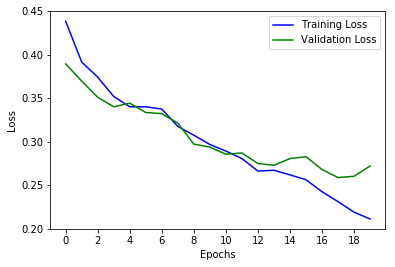

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [39]:
# Make a set of predictions for the training data
pred = model.predict_classes(X_train)

# Print performance details
print(metrics.classification_report(y_train_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_num, pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1029
           1       0.82      0.28      0.42       110
           2       0.75      0.95      0.84      1016
           3       1.00      0.56      0.72        93

   micro avg       0.81      0.81      0.81      2248
   macro avg       0.87      0.64      0.70      2248
weighted avg       0.83      0.81      0.80      2248

Confusion matrix
[[774   4 251   0]
 [ 25  31  54   0]
 [ 47   0 969   0]
 [ 14   3  24  52]]


Using SVM to compare metrics

In [51]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(bottleneck_features_train_plus_valid, y_train_plus_valid_num) 

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Using GridSearch to find optimum parameters

In [53]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'kernel': ['rbf'], 'decision_function_shape':['ovo'],
                     'gamma': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
                     'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5, verbose = 2, n_jobs = -1)
clf.fit(bottleneck_features_train_plus_valid, y_train_plus_valid_num) 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 11.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'kernel': ['rbf'], 'decision_function_shape': ['ovo'], 'gamma': [0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

Some more evaluation metrics

In [54]:
# Make a set of predictions for the validation data
pred = clf.predict(bottleneck_features_train)

# Print performance details
print(metrics.classification_report(y_train_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_num, pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       826
           1       0.95      0.85      0.89        84
           2       0.90      0.94      0.92       811
           3       0.96      0.84      0.90        77

   micro avg       0.91      0.91      0.91      1798
   macro avg       0.93      0.88      0.90      1798
weighted avg       0.91      0.91      0.91      1798

Confusion matrix
[[746   3  76   1]
 [ 10  71   3   0]
 [ 49   1 759   2]
 [  4   0   8  65]]


## Evaluation

In [55]:
# Make a set of predictions for the test data
pred = model.predict_classes(X_test)

# Print performance details
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       429
           1       0.72      0.79      0.75        48
           2       0.86      0.84      0.85       453
           3       0.71      0.71      0.71        34

   micro avg       0.84      0.84      0.84       964
   macro avg       0.78      0.80      0.79       964
weighted avg       0.84      0.84      0.84       964

Confusion matrix
[[364   7  55   3]
 [  7  38   2   1]
 [ 58   8 381   6]
 [  5   0   5  24]]


## Task 3

### Results

<table>
    <tr>
        <td >
            <img align="center" src="ml_player.PNG" width="500" height="400" /> 
        </td>
    </tr>
</table>

Results for Boltzmann with changed Warm up size pararmeter

<table>
    <tr>
        <td >
            <img align="center" src="boltzman_warm.PNG" width="500" height="400" /> 
        </td>
    </tr>
</table>

Boltzmann with default hyper-parameters

<table>
    <tr>
        <td >
            <img align="center" src="boltzmann_reward.PNG" width="500" height="400" /> 
        </td>
    </tr>
</table>

Results for epsilon greedy with changed warm up size parameters

<table>
    <tr>
        <td >
            <img align="center" src="greedy_warm.PNG" width="500" height="400" /> 
        </td>
    </tr>
</table>

Results for epsilon greedy with default parameters

<table>
    <tr>
        <td >
            <img align="center" src="greedy_reward.PNG" width="500" height="400" /> 
        </td>
    </tr>
</table>

### Conclusion

In this assignment, we conducted Lunar Lander experiment with ml_player and the reinforcement learning player. We have used evaluation metrics such as accuracy and F1 Score.

* For ml-player, we trained and created a model and used the model to train the player. We created Sequential, vgg16 and svm models to compare the performances. We found better results with SVM classification.

* The results could found in the graphs shown above. As we can see from the results, the greedy approach performed better and gave better rewards compared to the Boltzmann policy.

* We started training RL algorithm with EpsGreedyQPolicy and 200 episodes, the rewards mostly tend towards negative values, mean reward remained at -0.37 and total negative reward was -150. With higher episodes, we tend to get better rewards.

* For Boltzmann policy, the rewards were much lower and hence we can conclude that using EpsGreedyQPolicy yields better results.

* We also did experiments on the deep learning based approach to train the lunar lander player. We found that the rl-player gives better rewards than the supervised learning approach(ml-player).